# Exploration of Photon PAC data

Before we start building deep learning models on the PAC competition data, we should have a look at the data itself and try to get a sense of the task.

 - Is a simple model able to predict the target labels better than chance?
 - Are there confounding relationships between the observed variables?
 - Can a geometric manifold learning algorithm, [UMAP], find any structure that helps to predict the labels?




## Environment Setup
I used Conda to install jupyter, pandas, matplotlib, seaborn and statsmodels.
I installed UMAP into the same conda environment like this:
```
git clone https://github.com/lmcinnes/umap
cd umap
. ~/miniconda3/bin/activate
conda install seaborn
pip install -v .
```

## Data setup
I combined `PAC2018_Sites.xlsx` and `PAC2018_Covariates_Upload.xlsx` in a LibreOffice spreadsheet, and saved them to `paclabels.csv`.

This has 1792 entries with labels for depression/control, and some extra covariates (age, gender, total intracranial volume, and scanner ID).

I also unzipped the `pac2018.zip` file in the `pacdata` folder, which contains files like `PAC2018_0001.nii` (numbered up to `PAC2018_2240.nii`, non-consecutively).

TIV or Total Intracranial Volume is produced at the pre-processing step, when the contest organisers applied CAT12 which removes the skull from the image and normalises the scales: http://www.neuro.uni-jena.de/cat12/CAT12-Manual.pdf



In [1]:
import os.path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
import seaborn
import umap
import nibabel

Let's load the data into Pandas, and choose 200 datapoints for our validation set.

In [3]:
data = pd.read_csv("paclabels.csv")
VALIDATION_SIZE = 200

In [13]:
validation = np.random.choice(data.index, size=VALIDATION_SIZE, replace=False)
data['Validation'] = data.index.isin(validation)

In [14]:
data[~data.Validation].describe()

,Label,Age,Gender,TIV,Scanner
count,1592.000000,1592.000000,1592.000000,1592.000000,1592.000000
mean,1.422111,35.419598,1.579774,1573.161235,1.761935
std,0.494051,12.672139,0.493750,170.533596,0.785144
min,1.000000,16.000000,1.000000,-99.000000,1.000000
25%,1.000000,25.000000,1.000000,1472.000000,1.000000
50%,1.000000,31.000000,2.000000,1564.000000,2.000000
75%,2.000000,46.000000,2.000000,1674.252289,2.000000
max,2.000000,65.000000,2.000000,2706.755859,3.000000


In [15]:
data[data.Validation].describe()

,Label,Age,Gender,TIV,Scanner
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.435000,36.555000,1.655000,1554.559525,1.730000
std,0.497001,12.948176,0.476561,137.021801,0.774662
min,1.000000,17.000000,1.000000,1132.000000,1.000000
25%,1.000000,25.000000,1.000000,1470.353333,1.000000
50%,1.000000,33.000000,2.000000,1552.000000,2.000000
75%,2.000000,48.000000,2.000000,1628.750000,2.000000
max,2.000000,65.000000,2.000000,2036.000000,3.000000


We can see some of the relationships between the covariates visually with Seaborn's `pairplot` function.
This fits kernel density estimates to each factor, and linear regressions to each pair of factors.
(Linear regressions aren't great for the discrete scanner labels 1,2,3 so be careful interpreting the slopes.)

 - There are more Label=1 than Label=2 classes overall
 - The target labels aren't equally distributed across all scanners, and maybe vary with age
 - there are a lot of young subjects in the age distribution
 - the TIV might vary with age, gender and scanner ID?

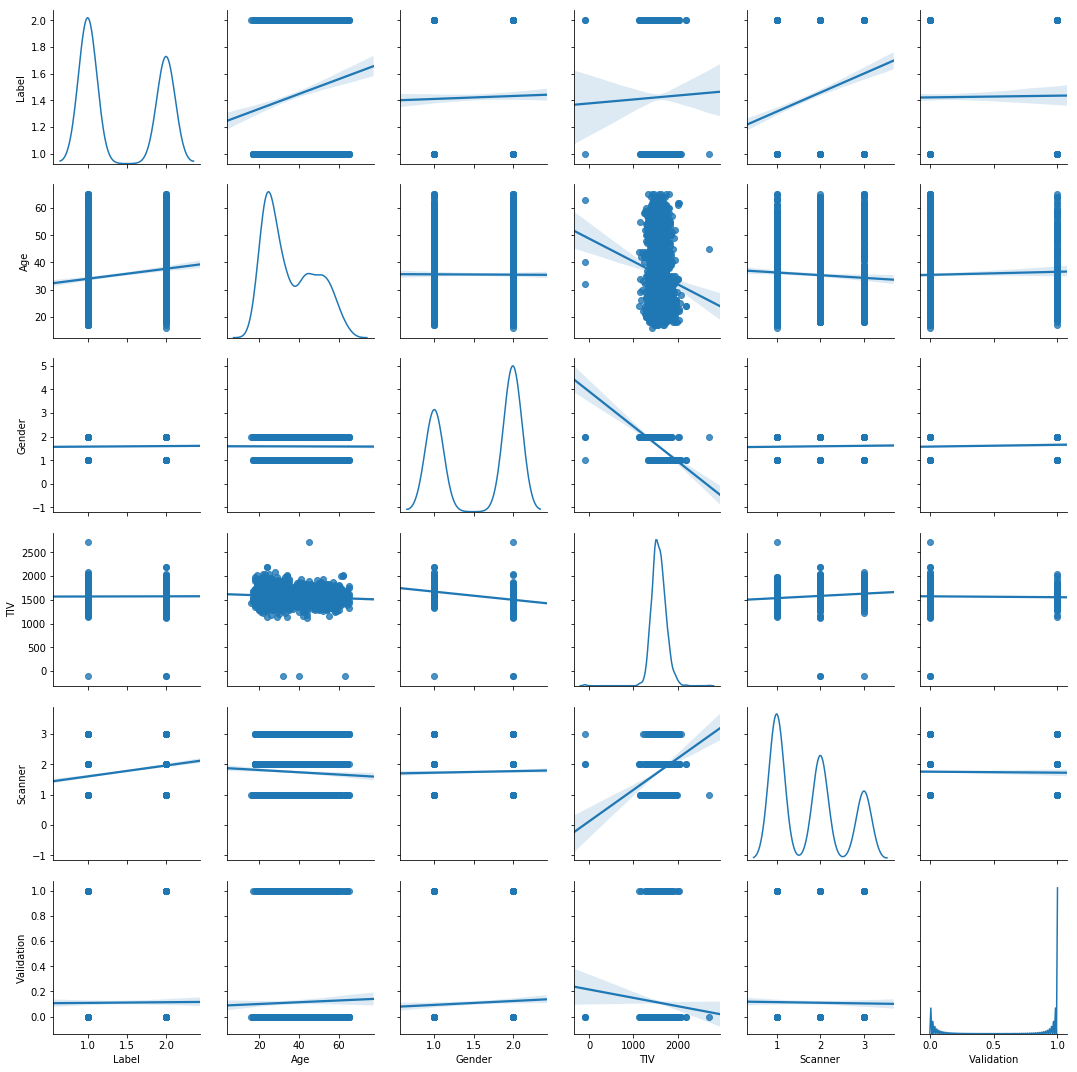

In [16]:
seaborn.pairplot(data, diag_kind='kde', kind='reg')

## Logistic regression

Let's fit a logistic regression classifier to the training set with Statsmodels as a baseline.

We can see how well this is able to predict the depression label, and then try to add features based on the neural imaging afterwards.



In [17]:
import statsmodels.formula.api as smf
import statsmodels.api as sm


In [18]:
# Intercept-only
fit = smf.glm(formula='C(Label) ~ 1', 
              family=sm.families.Binomial(),
              data=data[~data.Validation]).fit()

correct = fit.predict(data[data.Validation]).round() == 2 - data.Label[data.Validation]
correct.mean()

0.56499999999999995

In [19]:
# Scanner only
fit = smf.glm(formula='C(Label) ~ C(Scanner)', 
              family=sm.families.Binomial(),
              data=data[~data.Validation]).fit()

correct = fit.predict(data[data.Validation]).round() == 2 - data.Label[data.Validation]
correct.mean()

0.67500000000000004

In [20]:
# Linear fit to Age only 

fit = smf.glm(formula='C(Label) ~ Age', 
              family=sm.families.Binomial(),
              data=data[~data.Validation]).fit()

correct = fit.predict(data[data.Validation]).round() == 2 - data.Label[data.Validation]
correct.mean()

0.61499999999999999

In [21]:
# All covariates
fit = smf.glm(formula='C(Label) ~ Age +  Gender + TIV + C(Scanner)', 
              family=sm.families.Binomial(),
              data=data[~data.Validation]).fit()


In [22]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Generalized Linear Model Regression Results                        
==========================================================================================
Dep. Variable:     ['C(Label)[1]', 'C(Label)[2]']   No. Observations:                 1592
Model:                                        GLM   Df Residuals:                     1586
Model Family:                            Binomial   Df Model:                            5
Link Function:                              logit   Scale:                             1.0
Method:                                      IRLS   Log-Likelihood:                -1013.5
Date:                            Sat, 28 Apr 2018   Deviance:                       2027.1
Time:                                    10:59:47   Pearson chi2:                 1.60e+03
No. Iterations:                                 4                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.2658      0.753      1.681      0.093      -0.210       2.742
C(Scanner)[T.2]    -1.1641      0.124     -9.362      0.000      -1.408      -0.920
C(Scanner)[T.3]    -1.0851      0.144     -7.519      0.000      -1.368      -0.802
Age                -0.0260      0.004     -6.098      0.000      -0.034      -0.018
Gender              0.0609      0.127      0.481      0.631      -0.188       0.309
TIV                 0.0003      0.000      0.861      0.389      -0.000       0.001
===================================================================================
"""

In [23]:
correct = fit.predict(data[data.Validation]).round() == 2 - data.Label[data.Validation]
correct.mean()

0.67500000000000004

What do we see from these basic fits?

 - We get about 60% accuracy without any features, because the dataset is not balanced, but split 60/40
 - We get to 65% accuracy if we're told which scanner was used, because the datasets from the different scanners are balanced differently
 - Other features, notably age, apparently also have some predictive value.  But putting them altogether we still get 65% on our small validation set.
    

 

In [93]:
# k-fold cross-validation
def cross_val(data, formula, validation_size=VALIDATION_SIZE, K=20):
    results = []
    for k in range(K):
        validation = np.random.choice(data.index, size=VALIDATION_SIZE, replace=False)
        validation = data.index.isin(validation)
        fit = smf.glm(formula=formula, 
                      family=sm.families.Binomial(),
                      data=data[~validation]).fit()
        correct = fit.predict(data[validation]).round() == 2 - data.Label[validation]
        results.append(correct.mean())
    return pd.Series(results).describe()

In [94]:
cross_val(data, 'C(Label) ~ Age +  Gender + TIV + C(Scanner)')

count    20.000000
mean      0.650500
std       0.027716
min       0.600000
25%       0.635000
50%       0.655000
75%       0.665000
max       0.695000
dtype: float64

## Fitting image data with UMAP

We'll use an unsupervised dimension reduction technique UMAP on the image data.

This embeds the 3d voxel data for each image down to a vector, we'll use 4 dimensions.

We'll fit it to *all* the data including the training data!

 - It's unsupervised, so that doesn't let the classifier cheat as we're not showing it the target label
 - This means embeddings will be available for the test points, consistent with those for the training set.

In [33]:
X = np.zeros((1792,61,73,61),'f')

In [36]:
for i, pac_id in enumerate(data.PAC_ID):
    fn = os.path.join("pacdata","{}.nii".format(pac_id))
    X[i] = nibabel.load(fn).get_data().astype('f')[::2,::2,::2] # We're using stride 2 to shrink images to save memory


In [37]:
U = umap.UMAP(n_components=4)

In [40]:
U.fit(X.reshape(1792,-1))

UMAP(a=1.576943460405378, alpha=1.0, angular_rp_forest=False,
   b=0.8950608781227859, bandwidth=1.0, gamma=1.0, init='spectral',
   local_connectivity=1.0, metric='euclidean', metric_kwds={},
   min_dist=0.1, n_components=4, n_epochs=None, n_neighbors=15,
   negative_sample_rate=5, random_state=None, set_op_mix_ratio=1.0,
   spread=1.0, verbose=False)

Let's plot some projections of the embedding, using u0 as the color.

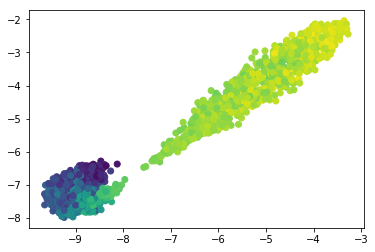

In [79]:
plt.scatter(*U.embedding_[:,1:3].T, c=U.embedding_[:,0])

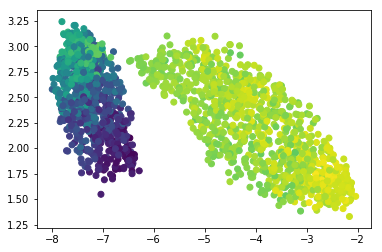

In [80]:
plt.scatter(*U.embedding_[:,2:4].T, c=U.embedding_[:,0])

Now we'll add the embedding data to the data frame

In [81]:
udata = pd.DataFrame(U.embedding_, columns=['u0','u1','u2','u3'])

In [64]:
dataplus = pd.concat([data, udata],axis=1)

It looks like the clusters visible in the embedding are probably to do with the scanner identity:

/home/ben/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


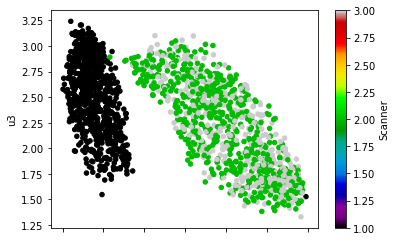

In [82]:
dataplus.plot.scatter(x='u2',y='u3',c='Scanner', cmap='spectral')

In [83]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [115]:
cross_val(dataplus, 'C(Label) ~ Age +  Gender + TIV + C(Scanner)', K=100)

count    100.000000
mean       0.651550
std        0.030655
min        0.580000
25%        0.625000
50%        0.650000
75%        0.670000
max        0.725000
dtype: float64

In [117]:
cross_val(dataplus, 'C(Label) ~ Age +  Gender + TIV + C(Scanner) + u0 + u1 + u2 + u3', K=100)

count    100.000000
mean       0.653650
std        0.026826
min        0.600000
25%        0.633750
50%        0.650000
75%        0.675000
max        0.720000
dtype: float64

In [116]:
cross_val(dataplus, 'C(Label) ~ C(Scanner) ', K=100)

count    100.000000
mean       0.623850
std        0.036054
min        0.515000
25%        0.603750
50%        0.627500
75%        0.645000
max        0.700000
dtype: float64

In [118]:
cross_val(dataplus, 'C(Label) ~ C(Scanner) + u0 + u1 + u2 + u3', K=100)

count    100.000000
mean       0.639450
std        0.029991
min        0.540000
25%        0.620000
50%        0.640000
75%        0.660000
max        0.695000
dtype: float64

Do the extra embedding parameters add anything?

None individually appears significant in the regression, but collectively they make a small contribution to the likelihood and lower the AIC by 6 points.

In [131]:
# Covariates only
fit = smf.glm(formula='C(Label) ~ Age +  Gender + TIV + C(Scanner)', 
              family=sm.families.Binomial(),
              data=dataplus).fit()
fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Generalized linear model
==============================================================================
Model:              GLM                            AIC:            2282.4085  
Link Function:      logit                          BIC:            -11108.6739
Dependent Variable: ['C(Label)[1]', 'C(Label)[2]'] Log-Likelihood: -1135.2    
Date:               2018-04-28 11:38               LL-Null:        -1221.1    
No. Observations:   1792                           Deviance:       2270.4     
Df Model:           5                              Pearson chi2:   1.80e+03   
Df Residuals:       1786                           Scale:          1.0000     
Method:             IRLS                                                      
--------------------------------------------------------------------------------
                       Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------------------
Intercept              1.3790     0.7226     1.9084   0.0563   -0.0373    2.7952
C(Scanner)[T.2]       -1.1806     0.1173   -10.0622   0.0000   -1.4106   -0.9506
C(Scanner)[T.3]       -1.1806     0.1364    -8.6529   0.0000   -1.4480   -0.9132
Age                   -0.0265     0.0040    -6.5807   0.0000   -0.0344   -0.0186
Gender                 0.0036     0.1204     0.0297   0.9763   -0.2324    0.2395
TIV                    0.0003     0.0004     0.9257   0.3546   -0.0004    0.0011
==============================================================================

"""

In [130]:
# Full model
fit = smf.glm(formula='C(Label) ~ Age +  Gender + TIV + C(Scanner) + u0 + u1 + u2 + u3', 
              family=sm.families.Binomial(),
              data=dataplus).fit()

fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Generalized linear model
==============================================================================
Model:              GLM                            AIC:            2274.8385  
Link Function:      logit                          BIC:            -11094.2796
Dependent Variable: ['C(Label)[1]', 'C(Label)[2]'] Log-Likelihood: -1127.4    
Date:               2018-04-28 11:37               LL-Null:        -1221.1    
No. Observations:   1792                           Deviance:       2254.8     
Df Model:           9                              Pearson chi2:   1.79e+03   
Df Residuals:       1782                           Scale:          1.0000     
Method:             IRLS                                                      
---------------------------------------------------------------------------------
                    Coef.     Std.Err.       z       P>|z|      [0.025     0.975]
---------------------------------------------------------------------------------
Intercept           4.9599      1.2718     3.8998    0.0001     2.4671     7.4527
C(Scanner)[T.2]    -2.1318      0.3230    -6.6009    0.0000    -2.7647    -1.4988
C(Scanner)[T.3]    -2.1535      0.3389    -6.3548    0.0000    -2.8176    -1.4893
Age                -0.0163      0.0055    -2.9592    0.0031    -0.0271    -0.0055
Gender              0.0214      0.1207     0.1774    0.8592    -0.2152     0.2580
TIV                -0.0005      0.0005    -1.0821    0.2792    -0.0014     0.0004
u0                  0.0448      0.1027     0.4363    0.6626    -0.1565     0.2462
u1                  0.0843      0.1776     0.4748    0.6349    -0.2637     0.4324
u2                  0.1537      0.1677     0.9168    0.3593    -0.1749     0.4824
u3                 -0.2978      0.2031    -1.4664    0.1425    -0.6958     0.1002
==============================================================================

"""

In [123]:
fit.aic

2274.8384865424755

We can also see that the embedding contains information about the age of the subjects, with R^2=0.367 and three of the four variables appearing with high significance in a linear regression.

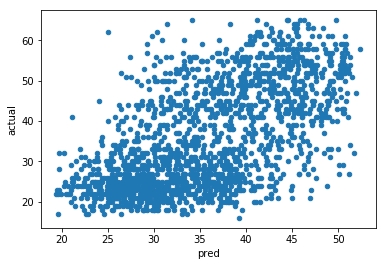

In [139]:
fit = smf.ols(formula="Age ~ u0 + u1 + u2 + u3",
                data=dataplus).fit()

pd.DataFrame({'actual':dataplus.Age, 'pred':fit.predict(dataplus)}).plot.scatter(x='pred',y='actual')

In [140]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     258.8
Date:                Sat, 28 Apr 2018   Prob (F-statistic):          1.49e-175
Time:                        11:40:47   Log-Likelihood:                -6687.9
No. Observations:                1792   AIC:                         1.339e+04
Df Residuals:                    1787   BIC:                         1.341e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5087      1.836      0.822      0.411      -2.092       5.109
u0             5.9850      0.415     14.433      0.000       5.172       6.798
u1            -0.3619      0.815     -0.444      0.657      -1.961       1.237
u2            -5.2486      0.759     -6.919      0.000      -6.736      -3.761
u3             3.1260      0.955      3.274      0.001       1.253       4.999
==============================================================================
Omnibus:                       36.647   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.051
Skew:                           0.331   Prob(JB):                     9.01e-09
Kurtosis:                       2.758   Cond. No.                         81.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Conclusion

The analysis above suggests that nearly all of what we learn from the images is related to the scanner identity and the age, and that these are already useful for predicting the target label. We don't add much predictive power by this off-the shelf approach. There's a hint of something, but it is too small to show up in our accuracy measure.
